# library

## for company computer

In [1]:
#import fastai from d
import os
import sys
module_path = os.path.abspath(os.path.join('/home/dg/fastai'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
module_path

'/home/dg/fastai'

## lib

In [3]:
from IPython.display import clear_output
import sys

In [4]:
import pandas as pd
import numpy as np
import fastai
from fastai.conv_learner import *

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.cross_validation import StratifiedShuffleSplit

/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
import gc

In [7]:
gc.enable()

# load data 2

## file list

In [8]:
#'application_train',
files = [['bureau', 'SK_ID_BUREAU'],
         ['bureau_balance', 'SK_ID_BUREAU'],
         ['credit_card_balance', 'SK_ID_CURR'],
         ['installments_payments', 'SK_ID_CURR'], 
         ['POS_CASH_balance', 'SK_ID_CURR'],
         ['previous_application', 'SK_ID_CURR'],
         ['application_train'], ['application_test']]

## function

In [9]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    
    y = y_fld
    if y_fld is not None:
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
        
    num_cols = df._get_numeric_data().columns
    sk_id_notin = ['SK_ID_BUREAU', 'SK_ID_CURR', 'SK_ID_PREV'] 
    num_cols = list([i for i in num_cols if i not in sk_id_notin and not i.endswith('na')])
    
    res = [pd.get_dummies(df, dummy_na=True), num_cols]
    if do_scale: res = res + [mapper]
    return res

In [10]:
def file_process(file_name = None, column_name = None, df_proc = None, limit = None):
    if file_name is not None:
        df = pd.read_csv(f'./data/{file_name}.csv', low_memory= False)
        if limit is not None:
            df = df[:limit]
        gc.collect()
        train_cats(df) #convert to category
        df_proc, num_cols = proc_df2(df, y_fld = None, max_n_cat= 10) #processing df
        del df; gc.collect()
    
    return df_proc, num_cols

# train and test

In [100]:
app_train, _ = file_process(file_name = files[6][0])
app_train_y = app_train['TARGET']

In [101]:
#target_lookup = pd.Series(app_train.TARGET.values,index=app_train.SK_ID_CURR).to_dict()
#np.save('target_lookup.npy', target_lookup)
target_lookup = np.load('target_lookup.npy').item()

In [102]:
app_test, _ = file_process(file_name = files[7][0])
app_train = app_train[list(app_test.columns)]

In [11]:
#sk_id_curr_test = list(app_test.SK_ID_CURR.values)
#np.save('sk_id_curr_test.npy', sk_id_curr_test)
sk_id_curr_test = np.load('sk_id_curr_test.npy')

## split train and valid set

In [105]:
stratSplit = StratifiedShuffleSplit(app_train_y, 1, test_size=0.2,random_state=42)
for train_idx,test_idx in stratSplit:
    x_train=app_train.iloc[train_idx]
    y_train=app_train_y[train_idx]
    
    x_val = app_train.iloc[test_idx]
    y_val = app_train_y[test_idx]

In [33]:
#x_train, x_val, y_train, y_val = train_test_split(app_train, app_train_y, test_size=0.2, random_state=22)

In [12]:
#sk_id_curr_train = list(set(x_train.SK_ID_CURR.values))
#np.save('sk_id_curr_train.npy', sk_id_curr_train)
sk_id_curr_train = np.load('sk_id_curr_train.npy')

In [13]:
#sk_id_curr_val = list(set(x_val.SK_ID_CURR.values))
#np.save('sk_id_curr_val.npy', sk_id_curr_val)
sk_id_curr_val = np.load('sk_id_curr_val.npy')

In [121]:
del x_train['SK_ID_CURR'], x_val['SK_ID_CURR'], app_train, app_test, app_train_y

In [122]:
gc.collect()

252

In [123]:
#x_train.reset_index(drop = True).to_feather('x_train')
x_train = pd.read_feather('x_train', nthreads=2)

#x_val.reset_index(drop = True).to_feather('x_val')
x_val = pd.read_feather('x_val', nthreads=2)

#y_train.to_pickle('y_train')
y_train = pd.read_pickle('y_train')

#y_val.to_pickle('y_val')
y_val = pd.read_pickle('y_val')

# random forrest

## function

In [21]:
def roc_auc(y_1,y_2): return roc_auc_score(y_1,y_2)

def print_score(m, x_train = x_train, y_train = y_train, x_val = x_val, y_val = y_val):
    #print(y_train.shape)
    #print(x_train.shape)
    print('roc_auc training set:' + str(roc_auc(y_train, m.predict_proba(x_train)[:,1])))
    print('roc_auc test set:' + str(roc_auc(y_val, m.predict_proba(x_val)[:,1])))
    
    print('\n')
    print('score training set:' + str(m.score(x_train, y_train)))
    print('score valid set:' + str(m.score(x_val, y_val)))
          
    if hasattr(m, 'oob_score_'): print('oob score:' + str(m.oob_score_))

In [22]:
def roc_curve_plot(m):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    fpr, tpr, thresholds = roc_curve(y_test, m.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, color='b',
             label= 'valid set', #'Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

## first run classify model

In [25]:
m = RandomForestClassifier(n_estimators=200, #increse
                           min_samples_leaf=40, #increse
                           oob_score=True, 
                           max_features='sqrt',
                           class_weight={0:1,1:2.5},
                           n_jobs=-1,
                           random_state= 2018) 


In [26]:
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.5},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=40,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=2018,
            verbose=0, warm_start=False)

In [27]:
print_score(m)

roc_auc training set:0.771297147813509
roc_auc test set:0.7357321340070588


score training set:0.9189172709830574
score valid set:0.9213534299139879
oob score:0.91752


## Feature importance

In [23]:
to_keep = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_CREDIT',
       'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL',
       'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE_Higher education', 'HOUR_APPR_PROCESS_START',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'TOTALAREA_MODE', 'OWN_CAR_AGE', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'YEARS_BEGINEXPLUATATION_MEDI', 'APARTMENTS_AVG', 'FLAG_DOCUMENT_3', 'APARTMENTS_MEDI',
       'YEARS_BEGINEXPLUATATION_AVG', 'LANDAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'EXT_SOURCE_1_na',
       'LANDAREA_AVG']

In [28]:
fi = rf_feat_importance(m, x_train);

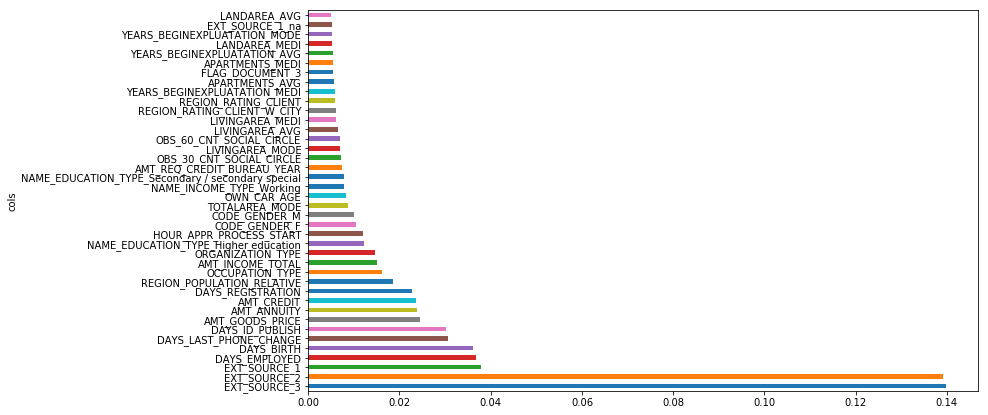

In [29]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:40])

In [30]:
#keep feature important
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

40

In [61]:
x_train_keep =  x_train[to_keep]
x_val_keep = x_val[to_keep]

In [62]:
m.fit(x_train_keep, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.5},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=40,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=2018,
            verbose=0, warm_start=False)

In [63]:
print_score(m, x_train = x_train_keep, x_val = x_val_keep)

roc_auc training set:0.8923350926573317
roc_auc test set:0.737298906261318


score training set:0.9211
score valid set:0.9208168707217534
oob score:0.91752


## remove redundant features

In [64]:
from scipy.cluster import hierarchy as hc

In [75]:
def dendogram(df):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(10,20))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
    plt.show()

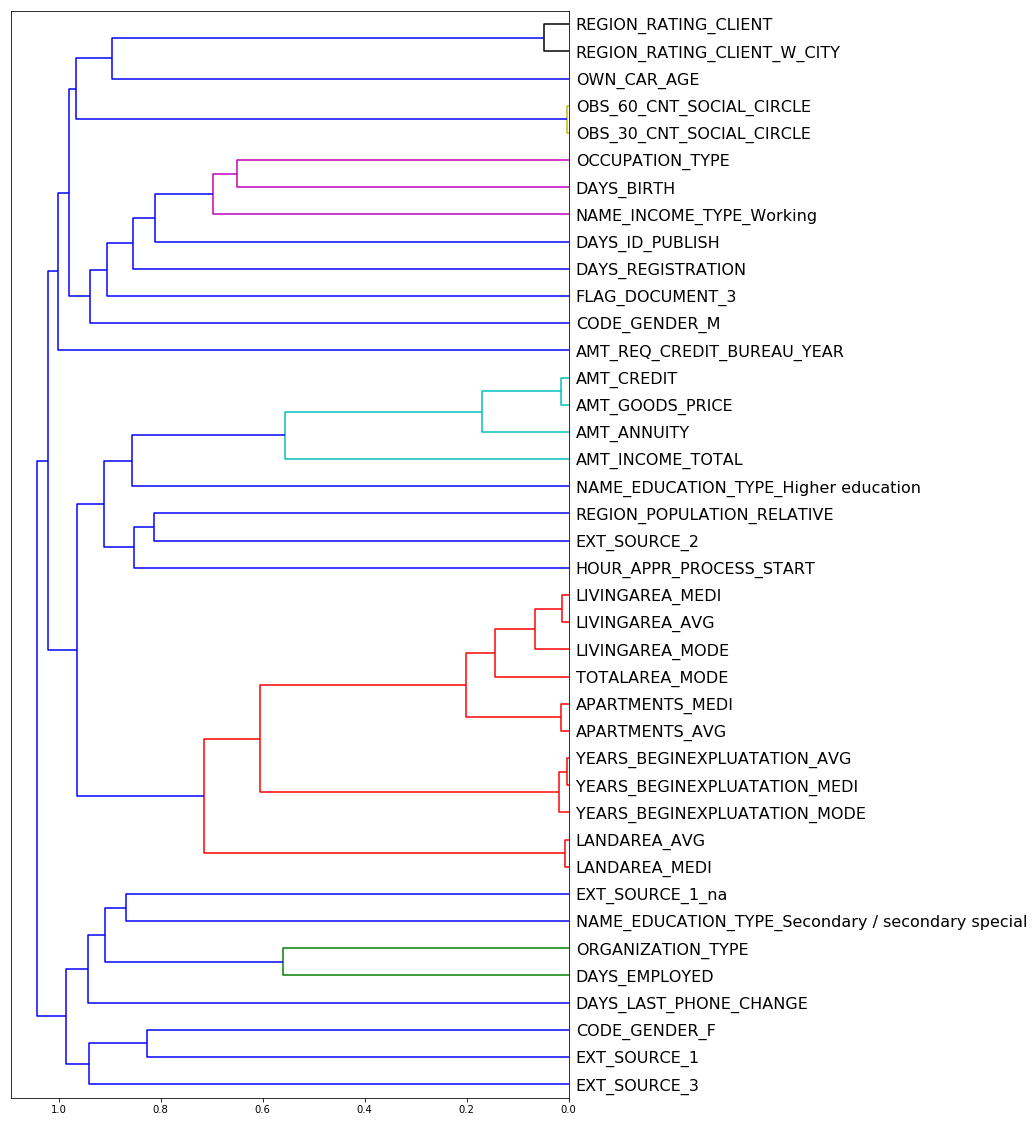

In [77]:
dendogram(x_train_keep)

In [55]:
def get_roc_auc(df, y_train = y_train, x_val = x_val, y_val = y_val):
    ma = m.fit(df, y_train)
    return(str(roc_auc(y_val, ma.predict_proba(x_val[df.columns.values])[:,1])))

In [78]:
for c in ('AMT_GOODS_PRICE', #
          'AMT_CREDIT',
          'AMT_ANNUITY', #
          'REGION_RATING_CLIENT',
           'REGION_RATING_CLIENT_W_CITY',
          'OBS_30_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE',
          'LIVINGAREA_MEDI',
           'LIVINGAREA_AVG',
           'LIVINGAREA_MODE',
           'APARTMENTS_MEDI',
            'APARTMENTS_AVG',
            'YEARS_BEGINEXPLUATATION_AVG',
            'YEARS_BEGINEXPLUATATION_MEDI',
             'YEARS_BEGINEXPLUATATION_MODE',
             'LANDAREA_AVG',
         'LANDAREA_MEDI'):
    print(c, get_roc_auc(df = x_train_keep.drop(c, axis=1)))

AMT_GOODS_PRICE 0.736951484596264
AMT_CREDIT 0.7384027159613691
AMT_ANNUITY 0.7376019270099866
REGION_RATING_CLIENT 0.7373029231396204
REGION_RATING_CLIENT_W_CITY 0.7375530641116179
OBS_30_CNT_SOCIAL_CIRCLE 0.7379031855858849
OBS_60_CNT_SOCIAL_CIRCLE 0.7386036182507423
LIVINGAREA_MEDI 0.7392620506403798
LIVINGAREA_AVG 0.7392111081592386
LIVINGAREA_MODE 0.7385255062030999
APARTMENTS_MEDI 0.7387378644396753
APARTMENTS_AVG 0.7388199349913669
YEARS_BEGINEXPLUATATION_AVG 0.7391048086440535
YEARS_BEGINEXPLUATATION_MEDI 0.7386976445791797
YEARS_BEGINEXPLUATATION_MODE 0.7389944265795313
LANDAREA_AVG 0.7380261071696855
LANDAREA_MEDI 0.7387952937597099


In [33]:
to_drop = ['AMT_CREDIT',
          #'AMT_ANNUITY',
           'REGION_RATING_CLIENT',
           'OBS_60_CNT_SOCIAL_CIRCLE',
           'LIVINGAREA_MEDI',
           'LIVINGAREA_AVG',
           #'LIVINGAREA_MODE',
           'APARTMENTS_AVG',
           'YEARS_BEGINEXPLUATATION_MODE',
           'YEARS_BEGINEXPLUATATION_AVG',
          'LANDAREA_MEDI']

In [84]:
print(get_roc_auc(x_train_keep.drop(to_drop, axis=1)))

0.7387517648087327


In [34]:
to_keep = [i for i in to_keep if i not in to_drop]

## tuning model

In [24]:
x_train = x_train[to_keep]
x_val = x_val[to_keep]

In [30]:
m = RandomForestClassifier(n_estimators=200, #increse
                           min_samples_leaf=50, #increse
                           oob_score=True, 
                           max_features='sqrt',
                           class_weight={0:1,1:3},
                           n_jobs=-1,
                           random_state= 2018)

In [31]:
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=2018,
            verbose=0, warm_start=False)

In [32]:
print_score(m, x_train = x_train, x_val = x_val)

roc_auc training set:0.8734059310021904
roc_auc test set:0.7458968536722599


score training set:0.9218724594322136
score valid set:0.917938962327041
oob score:0.9155677864134499


## save foldel

In [33]:
from sklearn.externals import joblib

In [34]:
joblib.dump(m, 'rf_model')

['rf_model']

# CNN for all app

## function

### function create dataset

In [8]:
def fill_maxtrix(mtr, maxa):
    if mtr.shape[1] < maxa:
        z_array = np.zeros((maxa-mtr.shape[1], mtr.shape[2]), dtype = np.float32)
        a2 = np.array([np.vstack((mtr[0,:,:], z_array))], dtype = np.float32)
        return(a2)
    else:
        return(mtr)

In [9]:
def cnn_data(dfr, num_col = 'DAYS_CREDIT', maxa = 116):
    dfr = dfr.sort_values(by=num_col, ascending = False)
    if 'SK_ID_CURR' in dfr.columns.values: dfr = dfr.drop('SK_ID_CURR', axis=1)
    if 'SK_ID_BUREAU' in dfr.columns.values: dfr = dfr.drop('SK_ID_BUREAU', axis=1)
    if 'SK_ID_PREV' in dfr.columns.values: dfr = dfr.drop('SK_ID_PREV', axis=1)
        
    a2 = np.array([dfr.as_matrix()], dtype = np.float32)
    a2 = fill_maxtrix(a2, maxa)
    return a2

### function create model

In [20]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        #self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(128 * block.expansion, 10)
        self.relu = nn.ReLU()
        self.out = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        #x = self.avgpool(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [21]:
def a_loss(inp,targ):
    inp_flat = inp.view(-1)
    targ_flat = targ.float().view(-1)
    return F.binary_cross_entropy(inp_flat, targ_flat, targ_flat + 0.8)

## bureau

### load and save data

In [25]:
bureau, bureau_num_col = file_process(file_name = files[0][0], column_name = files[0][1])

In [48]:
#bb_two_id = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].drop_duplicates()
#bb_two_id.reset_index(drop = True).to_feather('bb_two_id')
bb_two_id = pd.read_feather('bb_two_id', nthreads=2)

In [26]:
del bureau['SK_ID_BUREAU']

In [27]:
#bureau_max_row = max(bureau.groupby('SK_ID_CURR').count()['DAYS_CREDIT'].values)
bureau_max_row = 116

In [28]:
bureau_num_col = ['DAYS_CREDIT']

In [29]:
#bureau_sk_id_curr = set(bureau.SK_ID_CURR)
#np.save('bureau_sk_id_curr.npy', bureau_sk_id_curr)
bureau_sk_id_curr = np.load('bureau_sk_id_curr.npy')

In [30]:
bureau_cnn = bureau.groupby(['SK_ID_CURR']).apply(lambda x: cnn_data(x))
bureau_cnn.to_pickle('bureau_cnn')
#bureau_cnn = pd.read_pickle('bureau_cnn')

/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [31]:
#bureau_x_train_id = [i for i in sk_id_curr_train if i in bureau_sk_id_curr]
#np.save('bureau_x_train_id.npy', bureau_x_train_id)
bureau_x_train_id = np.load('bureau_x_train_id.npy')

In [33]:
#bureau_x_valid_id = [i for i in sk_id_curr_val if i in bureau_sk_id_curr]
#np.save('bureau_x_valid_id.npy', bureau_x_valid_id)
bureau_x_valid_id = np.load('bureau_x_valid_id.npy')

In [9]:
#bureau_x_test_id = [i for i in sk_id_curr_test if i in bureau_sk_id_curr]
#np.save('bureau_x_test_id.npy', bureau_x_test_id)
bureau_x_test_id = set(np.load('bureau_x_test_id.npy'))

In [10]:
#bureau_x_train = bureau_cnn[bureau_x_train_id]
#bureau_x_train = np.array([i for i in bureau_x_train])
#np.save('bureau_x_train.npy', bureau_x_train)
bureau_x_train = np.load('bureau_x_train.npy')

In [11]:
#bureau_y_train = [target_lookup[i] for i in bureau_x_train_id]
#np.save('bureau_y_train.npy', np.array(bureau_y_train))
bureau_y_train = np.load('bureau_y_train.npy')

In [12]:
#bureau_x_val = bureau_cnn[bureau_x_valid_id]
#bureau_x_val = np.array([i for i in bureau_x_val])
#np.save('bureau_x_val.npy', bureau_x_val)
bureau_x_val = np.load('bureau_x_val.npy')

In [13]:
#bureau_y_val = [target_lookup[i] for i in bureau_x_valid_id]
#np.save('bureau_y_val.npy', np.array(bureau_y_val))
bureau_y_val = np.load('bureau_y_val.npy')

In [14]:
#bureau_x_test = bureau_cnn[bureau_x_test_id]
#bureau_x_test.to_pickle('bureau_x_test')
bureau_x_test = pd.read_pickle('bureau_x_test')

### fit

In [17]:
bureau_data = ImageClassifierData.from_arrays(path = './', 
                                               trn = (bureau_x_train, bureau_y_train), 
                                               val = (bureau_x_val, bureau_y_val))

In [18]:
bureau_learn = ConvLearner.from_model_data(resnet18(), bureau_data)

In [19]:
bureau_learn.crit = a_loss

In [20]:
bureau_learn.fit(lrs = 0.001, n_cycle = 3, use_wd_sched=True, wds=1e-4)

epoch      trn_loss   val_loss   accuracy                      
    0      0.357368   0.370579   0.925023  
    1      0.376332   0.366974   0.925023                      
    2      0.384653   0.365992   0.925023                      



[array([0.36599]), 0.92502325228252]

In [21]:
bureau_learn.save('bureau')

In [27]:
bureau_learn.load('bureau')

KeyError: 'unexpected key "layers2.0.a" in state_dict'

### predict

In [22]:
def bureau_predict(id_test):
    if id_test in bureau_x_test_id:
        x_test = np.array([bureau_x_test[id_test]])
        pred = bureau_learn.predict_array(x_test)[0][0]
        return pred
    else:
        return -1

In [23]:
bureau_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: bureau_predict(t.iloc[0,0]))

In [25]:
bureau_pred.to_pickle('bureau_pred')

## bureau balance

### load data

In [62]:
#load file
bureau_balance, bureau_balance_num_col = file_process(file_name = files[1][0], column_name = files[1][1])

In [63]:
bb_num_col = 'MONTHS_BALANCE'

In [64]:
#bb_max_row = max(bureau_balance.groupby('SK_ID_BUREAU').count()['MONTHS_BALANCE'].values)
bb_max_row = 97

In [42]:
#bb_sk_id_bureau = set(bureau_balance.SK_ID_BUREAU)
#bb_sk_id_bureau = list(bb_sk_id_bureau)
#np.save('bb_sk_id_bureau.npy',bb_sk_id_bureau)
bb_sk_id_bureau = set( np.load('bb_sk_id_bureau.npy'))

In [38]:
#bb_bureau_to_curr = pd.Series(bb_two_id.SK_ID_CURR.values,index=bb_two_id.SK_ID_BUREAU).to_dict()
#np.save('bb_bureau_to_curr.npy',bb_bureau_to_curr)
bb_bureau_to_curr = np.load('bb_bureau_to_curr.npy').item() 

In [27]:
#bb_curr_to_bureau = {k: list(v) for k,v in bb_two_id.groupby("SK_ID_CURR")["SK_ID_BUREAU"]}
#np.save('bb_curr_to_bureau'x, bb_curr_to_bureau)
bb_curr_to_bureau = np.load('bb_curr_to_bureau.npy').item()

In [9]:
#bb_cnn = bureau_balance.groupby(['SK_ID_BUREAU']).apply(lambda x: cnn_data(x, num_col = bb_num_col, maxa = bb_max_row))
#bb_cnn.to_pickle('bb_cnn')
bb_cnn = pd.read_pickle('bb_cnn')

In [10]:
#bb_x_train_id = [bb_curr_to_bureau[i] for i in sk_id_curr_train if i in bureau_sk_id_curr]
#bb_x_train_id = list(itertools.chain.from_iterable(bb_x_train_id))
#bb_x_train_id = [i for i in bb_x_train_id if i in bb_sk_id_bureau]
#np.save('bb_x_train_id.npy', bb_x_train_id)
bb_x_train_id = np.load('bb_x_train_id.npy')

In [11]:
#bb_x_val_id = [bb_curr_to_bureau[i] for i in sk_id_curr_val if i in bureau_sk_id_curr]
#bb_x_val_id = list(itertools.chain.from_iterable(bb_x_val_id))
#bb_x_val_id = [i for i in bb_x_val_id if i in bb_sk_id_bureau]
#np.save('bb_x_val_id.npy', bb_x_val_id)
bb_x_val_id = np.load('bb_x_val_id.npy')

In [12]:
#bb_x_test_id = [bb_curr_to_bureau[i] for i in sk_id_curr_test if i in bureau_sk_id_curr]
#bb_x_test_id = list(itertools.chain.from_iterable(bb_x_test_id))
#bb_x_test_id = [i for i in bb_x_test_id if i in bb_sk_id_bureau]
#np.save('bb_x_test_id.npy', bb_x_test_id)
bb_x_test_id = set(np.load('bb_x_test_id.npy'))

In [13]:
#bb_x_train = bb_cnn[bb_x_train_id]
#bb_x_train = np.array([i for i in bb_x_train])
#np.save('bb_x_train.npy', bb_x_train)
bb_x_train = np.load('bb_x_train.npy')

In [14]:
#bb_y_train = [target_lookup[bb_bureau_to_curr[i]] for i in bb_x_train_id]
#np.save('bb_y_train.npy', np.array(bb_y_train))
bb_y_train = np.load('bb_y_train.npy')

In [15]:
#bb_x_val = bb_cnn[bb_x_val_id]
#bb_x_val = np.array([i for i in bb_x_val])
#np.save('bb_x_val.npy', bb_x_val)
bb_x_val = np.load('bb_x_val.npy')

In [16]:
#bb_y_val = [target_lookup[bb_bureau_to_curr[i]] for i in bb_x_val_id]
#np.save('bb_y_val.npy', np.array(bb_y_val))
bb_y_val = np.load('bb_y_val.npy')

In [17]:
#bb_x_test = bb_cnn[bb_x_test_id]
#bb_x_test.to_pickle('bb_x_test')
bb_x_test = pd.read_pickle('bb_x_test')

### fit data

In [18]:
bb_data = ImageClassifierData.from_arrays(path = './', 
                                           trn = (bb_x_train, bb_y_train), 
                                           val = (bb_x_val, bb_y_val))

In [19]:
bb_learn2 = ConvLearner.from_model_data(resnet18(), bb_data)

In [20]:
bb_learn2.crit = a_loss

In [21]:
bb_learn2.fit(lrs = 0.001, n_cycle= 6, use_wd_sched=True, wds=1e-4) 
##cycle_len=4, cycle_mult=2,

epoch      trn_loss   val_loss   accuracy                      
    0      0.411252   0.397716   0.917452  
    1      0.39845    0.396876   0.917452                      
    2      0.397987   0.396208   0.917452                      
    3      0.381686   0.397225   0.917452                      
    4      0.405072   0.39616    0.917452                      
    5      0.415471   0.397353   0.917452                      



[array([0.39735]), 0.9174515667156925]

In [22]:
bb_learn2.save('bureau_balance')

In [26]:
bb_learn2.load('bureau_balance')

### predict

In [57]:
def bb_predict(id_test):
    pred = -1
    if id_test in bb_curr_to_bureau.keys():
        #print(id_test)
        #pdb.set_trace()
        id_test_bb = [i for i in bb_curr_to_bureau[id_test] if i in bb_sk_id_bureau]
        if len(id_test_bb) != 0:
            x_test = np.array([i for i in bb_x_test[id_test_bb]])
            pred = bb_learn2.predict_array(x_test)
            pred = [i[0] for i in pred]
    return pred

In [58]:
bb_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: bb_predict(t.iloc[0,0]))

In [60]:
bb_pred.to_pickle('bb_pred')

## previous application

### load data

In [36]:
#previous application
previous_application, pa_num_cols = file_process(files[5][0], files[5][1])

In [37]:
pa_num_cols = 'AMT_ANNUITY'

In [38]:
del previous_application['SK_ID_PREV']

In [39]:
#pa_max_row = max(previous_application.groupby('SK_ID_CURR').count()['AMT_ANNUITY'].values)
pa_max_row = 77

In [4]:
#pa_sk_id_curr = set(previous_application.SK_ID_CURR)
#pa_sk_id_curr = list(pa_sk_id_curr)
#np.save('pa_sk_id_curr.npy', pa_sk_id_curr)
pa_sk_id_curr = set(np.load('pa_sk_id_curr.npy'))

In [ ]:
#pa_cnn = previous_application.groupby(['SK_ID_CURR']).apply(lambda x: cnn_data(x, num_col = pa_num_cols, maxa = pa_max_row))
#pa_cnn.to_pickle('pa_cnn')
pa_cnn = pd.read_pickle('pa_cnn')

In [5]:
#pa_x_train_id = [i for i in sk_id_curr_train if i in pa_sk_id_curr]
#np.save('pa_x_train_id.npy', pa_x_train_id)
pa_x_train_id = np.load('pa_x_train_id.npy')

In [9]:
#pa_x_valid_id = [i for i in sk_id_curr_val if i in pa_sk_id_curr]
#np.save('pa_x_valid_id.npy', pa_x_valid_id)
pa_x_train_id = np.load('pa_x_valid_id.npy')

In [26]:
#pa_x_test_id = [i for i in sk_id_curr_test if i in pa_sk_id_curr]
#np.save('pa_x_test_id.npy', pa_x_test_id)
pa_x_test_id = set(np.load('pa_x_test_id.npy'))

In [56]:
#pa_x_train = pa_cnn[pa_x_train_id]
#pa_x_train = np.array([i for i in pa_x_train])
#np.save('pa_x_train.npy', pa_x_train)
pa_x_train = np.load('pa_x_train.npy')

In [57]:
#pa_y_train = [target_lookup[i] for i in pa_x_train_id]
#np.save('pa_y_train.npy', np.array(pa_y_train))
pa_y_train = np.load('pa_y_train.npy')

In [58]:
#pa_x_val = pa_cnn[pa_x_valid_id]
#pa_x_val = np.array([i for i in pa_x_val])
#np.save('pa_x_val.npy', pa_x_val)
pa_x_val = np.load('pa_x_val.npy')

In [59]:
#pa_y_val = [target_lookup[i] for i in pa_x_valid_id]
#np.save('pa_y_val.npy', np.array(pa_y_val))
pa_y_val = np.load('pa_y_val.npy')

In [60]:
#pa_x_test = pa_cnn[pa_x_test_id]
#pa_x_test.to_pickle('pa_x_test')
pa_x_test = pd.read_pickle('pa_x_test')

### fit

In [85]:
previous_application_data = ImageClassifierData.from_arrays(path = './', 
                                                           trn = (pa_x_train, pa_y_train), 
                                                           val = (pa_x_val, pa_y_val))

In [86]:
previous_application_learn = ConvLearner.from_model_data(resnet18(), previous_application_data)

In [87]:
previous_application_learn.crit = a_loss

In [88]:
previous_application_learn.fit(lrs = 0.001, n_cycle= 3, use_wd_sched=True, wds=1e-4)

epoch      trn_loss   val_loss   accuracy                      
    0      0.381989   0.393092   0.920289  
    1      0.385878   0.386807   0.920289                      
    2      0.416785   0.386631   0.920289                      



[array([0.38663]), 0.9202887368640024]

In [89]:
previous_application_learn.save('previous_application')

#### load model

In [28]:
previous_application_learn = resnet18()

In [32]:
load_model(previous_application_learn, './models/previous_application.h5')

### predict

In [92]:
def pa_predict(id_test):
    if id_test in pa_x_test_id:
        x_test = np.array([pa_x_test[id_test]])
        pred = previous_application_learn.predict_array(x_test)[0][0]
        return pred
    else:
        return -1

In [93]:
pa_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: pa_predict(t.iloc[0,0]))

In [95]:
pa_pred.to_pickle('pa_pred')

## pos cash

### load data

In [19]:
pos_cash, pc_num_cols = file_process(files[4][0], files[4][1])

In [21]:
pc_num_cols = 'MONTHS_BALANCE'

In [22]:
#pc_max_row = max(pos_cash.groupby('SK_ID_PREV').count()['MONTHS_BALANCE'].values)
pc_max_row = 96

In [6]:
#pc_sk_id_prev = set(pos_cash.SK_ID_PREV)
#pc_sk_id_prev = list(pc_sk_id_prev)
#np.save('pc_sk_id_prev.npy',pc_sk_id_prev)
pc_sk_id_prev = set(np.load('pc_sk_id_prev.npy'))

In [7]:
#pc_sk_id_curr = set(pos_cash.SK_ID_CURR)
#pc_sk_id_curr = list(pc_sk_id_curr)
#np.save('pc_sk_id_curr.npy',pc_sk_id_curr)
pc_sk_id_curr = set(np.load('pc_sk_id_curr.npy'))

In [12]:
#pc_two_id = pos_cash[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates()
#pc_two_id.reset_index(drop= True).to_feather('pc_two_id')
pc_two_id = pd.read_feather('pc_two_id', nthreads=2)

In [30]:
#pc_curr_to_prev = {k: list(v) for k,v in pc_two_id.groupby("SK_ID_CURR")["SK_ID_PREV"]}
#np.save('pc_curr_to_prev', pc_curr_to_prev)
pc_curr_to_prev = np.load('pc_curr_to_prev.npy').item()

In [13]:
#pc_prev_to_curr = pd.Series(pc_two_id.SK_ID_CURR.values,index=pc_two_id.SK_ID_PREV).to_dict()
#np.save('pc_prev_to_curr.npy',pc_prev_to_curr)
pc_prev_to_curr = np.load('pc_prev_to_curr.npy').item() 

In [9]:
#pc_cnn = pos_cash.groupby(['SK_ID_PREV']).apply(lambda x: cnn_data(x, num_col = pc_num_cols, maxa = pc_max_row))
#pc_cnn.to_pickle('pc_cnn')
pc_cnn = pd.read_pickle('pc_cnn')

In [10]:
#pc_x_train_id = [pc_curr_to_prev[i] for i in sk_id_curr_train if i in pc_sk_id_curr]
#pc_x_train_id = list(itertools.chain.from_iterable(pc_x_train_id))
#np.save('pc_x_train_id.npy', pc_x_train_id)
pc_x_train_id = np.load('pc_x_train_id.npy')

In [11]:
#pc_x_valid_id = [pc_curr_to_prev[i] for i in sk_id_curr_val if i in pc_sk_id_curr]
#pc_x_valid_id = list(itertools.chain.from_iterable(pc_x_valid_id))
#np.save('pc_x_valid_id.npy', pc_x_valid_id)
pc_x_valid_id = np.load('pc_x_valid_id.npy')

In [10]:
#pc_x_test_id = [pc_curr_to_prev[i] for i in sk_id_curr_test if i in pc_sk_id_curr]
#pc_x_test_id = list(itertools.chain.from_iterable(pc_x_test_id))
#np.save('pc_x_test_id.npy', pc_x_test_id)
pc_x_test_id = set(np.load('pc_x_test_id.npy'))

In [11]:
#pc_x_train = pc_cnn[pc_x_train_id]
#pc_x_train = np.array([i for i in pc_x_train])
#np.save('pc_x_train.npy', pc_x_train)
pc_x_train = np.load('pc_x_train.npy')

In [12]:
#pc_y_train = [target_lookup[pc_prev_to_curr[i]] for i in pc_x_train_id]
#np.save('pc_y_train.npy', np.array(pc_y_train))
pc_y_train = np.load('pc_y_train.npy')

In [13]:
#pc_x_val = pc_cnn[pc_x_valid_id]
#pc_x_val = np.array([i for i in pc_x_val])
#np.save('pc_x_val.npy', pc_x_val)
pc_x_val = np.load('pc_x_val.npy')

In [14]:
#pc_y_val = [target_lookup[pc_prev_to_curr[i]] for i in pc_x_valid_id]
#np.save('pc_y_val.npy', np.array(pc_y_val))
pc_y_val = np.load('pc_y_val.npy')

In [15]:
#pc_x_test = pc_cnn[pc_x_test_id]
#pc_x_test.to_pickle('pc_x_test')
pc_x_test = pd.read_pickle('pc_x_test')

### fit

In [16]:
pos_cash_data = ImageClassifierData.from_arrays(path = './', 
                                       trn = (pc_x_train, pc_y_train), 
                                       val = (pc_x_val, pc_y_val))

In [17]:
pos_cash_learn = ConvLearner.from_model_data(resnet18(), pos_cash_data)

In [18]:
pos_cash_learn.crit = a_loss

In [20]:
pos_cash_learn.fit(lrs = 0.001, n_cycle= 2, wds=1e-4)
##??cycle_len=4, cycle_mult=2, wds=1e-4, , use_wd_sched=True, 
#0.368153

epoch      trn_loss   val_loss   accuracy                       
    0      0.365484   0.368677   0.927069  
    1      0.374571   0.36822    0.927069                        



[array([0.36822]), 0.9270687762028349]

In [22]:
pos_cash_learn.save('pos_cash')

In [ ]:
pos_cash_learn.load('pos_cash')

### predict

In [76]:
def pc_predict(id_test):
    if id_test in pc_curr_to_prev.keys():
        id_test_pc = pc_curr_to_prev[id_test]
        x_test = np.array([i for i in pc_x_test[id_test_pc]])
        pred = pos_cash_learn.predict_array(x_test)
        pred = [i[0] for i in pred]
        return pred
    else:
        return -1

In [ ]:
pc_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: pc_predict(t.iloc[0,0]))

In [81]:
pc_pred.to_pickle('pc_pred')

In [61]:
pc_pred = pd.read_pickle('pc_predict')

## cc balance

### load data

In [98]:
cc_balance, cc_num_cols = file_process(files[2][0], files[2][1])

KeyboardInterrupt: 

In [ ]:
cc_num_cols = 'MONTHS_BALANCE'

In [ ]:
#cc_max_row = max(cc_balance.groupby('SK_ID_PREV').count()['SK_ID_CURR'].values)
cc_max_row = 96

In [ ]:
#cc_sk_id_prev = set(cc_balance.SK_ID_PREV)
#cc_sk_id_prev = list(cc_sk_id_prev)
#np.save('cc_sk_id_prev.npy',cc_sk_id_prev)
cc_sk_id_prev = set(np.load('cc_sk_id_prev.npy'))

In [126]:
#cc_sk_id_curr = set(cc_balance.SK_ID_CURR)
#cc_sk_id_curr = list(cc_sk_id_curr)
#np.save('cc_sk_id_curr.npy',cc_sk_id_curr)
cc_sk_id_curr = set(np.load('cc_sk_id_curr.npy'))

In [14]:
#cc_two_id = cc_balance[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates()
#cc_two_id.reset_index(drop= True).to_feather('cc_two_id')
cc_two_id = pd.read_feather('cc_two_id', nthreads=2)

In [78]:
#cc_curr_to_prev = {k: list(v) for k,v in cc_two_id.groupby("SK_ID_CURR")["SK_ID_PREV"]}
#np.save('cc_curr_to_prev.npy', cc_curr_to_prev)
cc_curr_to_prev = np.load('cc_curr_to_prev.npy').item()

In [79]:
#cc_prev_to_curr = pd.Series(cc_two_id.SK_ID_CURR.values,index=cc_two_id.SK_ID_PREV).to_dict()
#np.save('cc_prev_to_curr.npy',cc_prev_to_curr)
cc_prev_to_curr = np.load('cc_prev_to_curr.npy').item() 

In [99]:
#cc_cnn = cc_balance.groupby(['SK_ID_PREV']).apply(lambda x: cnn_data(x, num_col = cc_num_cols, maxa = cc_max_row))
#cc_cnn.to_pickle('cc_cnn')
cc_cnn = pd.read_pickle('cc_cnn')

In [25]:
#cc_x_train_id = [cc_curr_to_prev[i] for i in sk_id_curr_train if i in cc_sk_id_curr]
#cc_x_train_id = list(itertools.chain.from_iterable(cc_x_train_id))
#np.save('cc_x_train_id.npy', cc_x_train_id)
cc_x_train_id = np.load('cc_x_train_id.npy')

In [26]:
#cc_x_valid_id = [cc_curr_to_prev[i] for i in sk_id_curr_val if i in cc_sk_id_curr]
#cc_x_valid_id = list(itertools.chain.from_iterable(cc_x_valid_id))
#np.save('cc_x_valid_id.npy', cc_x_valid_id)
cc_x_valid_id = np.load('cc_x_valid_id.npy')

In [63]:
#cc_x_test_id = [cc_curr_to_prev[i] for i in sk_id_curr_test if i in cc_sk_id_curr]
#cc_x_test_id = list(itertools.chain.from_iterable(cc_x_test_id))
#np.save('cc_x_test_id.npy', cc_x_test_id)
cc_x_test_id = np.load('cc_x_test_id.npy')

In [64]:
#cc_x_train = cc_cnn[cc_x_train_id]
#cc_x_train = np.array([i for i in cc_x_train])
#np.save('cc_x_train.npy', cc_x_train)
cc_x_train = np.load('cc_x_train.npy')

In [65]:
#cc_y_train = [target_lookup[cc_prev_to_curr[i]] for i in cc_x_train_id]
#np.save('cc_y_train.npy', np.array(cc_y_train))
cc_y_train = np.load('cc_y_train.npy')

In [66]:
#cc_x_val = cc_cnn[cc_x_valid_id]
#cc_x_val = np.array([i for i in cc_x_val])
#np.save('cc_x_val.npy', cc_x_val)
cc_x_val = np.load('cc_x_val.npy')

In [67]:
#cc_y_val = [target_lookup[cc_prev_to_curr[i]] for i in cc_x_valid_id]
#np.save('cc_y_val.npy', np.array(cc_y_val))
cc_y_val = np.load('cc_y_val.npy')

In [68]:
#cc_x_test = cc_cnn[cc_x_test_id]
#cc_x_test.to_pickle('cc_x_test')
cc_x_test = pd.read_pickle('cc_x_test')

### fit

In [160]:
cc_balance_data = ImageClassifierData.from_arrays(path = './', 
                                       trn = (cc_x_train, cc_y_train), 
                                       val = (cc_x_val, cc_y_val))

In [165]:
cc_balance_learn = ConvLearner.from_model_data(resnet18(), cc_balance_data)

In [166]:
cc_balance_learn.crit = a_loss

In [169]:
cc_balance_learn.fit(lrs = 0.0001, n_cycle= 10, use_wd_sched=True, wds=1e-2)
##??cycle_len=4, cycle_mult=2,,  wds=1e-4

epoch      trn_loss   val_loss   accuracy                      
    0      0.331147   0.423531   0.913405  
    1      0.337131   0.43455    0.913405                      
    2      0.341808   0.43458    0.913405                      
    3      0.350078   0.431351   0.913405                      
    4      0.319716   0.441057   0.913405                      
    5      0.336759   0.4341     0.913405                      
    6      0.331279   0.436762   0.913405                      
    7      0.342084   0.43498    0.913405                      
    8      0.319419   0.44223    0.913405                      
    9      0.323237   0.446893   0.913405                      


[array([0.44689]), 0.9134049185455678]

In [76]:
cc_balance_learn.save('cc_balance')

In [ ]:
cc_balance_learn.load('cc_balance')

### predict

In [83]:
def cc_predict(id_test):
    pred = -1
    if id_test in cc_curr_to_prev.keys():
        id_test_pc = cc_curr_to_prev[id_test]
        x_test = np.array([i for i in cc_x_test[id_test_pc]])
        pred = cc_balance_learn.predict_array(x_test)
        pred = [i[0] for i in pred]
    return pred

In [84]:
cc_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: cc_predict(t.iloc[0,0]))

In [85]:
cc_pred.to_pickle('cc_pred')

In [61]:
#cc_pred = pd.read_pickle('cc_pred')

## ins pay

### load data

In [20]:
ins_pay, ip_num_cols = file_process(files[3][0], files[3][1])

In [21]:
ip_num_cols = 'DAYS_INSTALMENT'

In [22]:
#ip_max_row = max(ins_pay.groupby('SK_ID_PREV').count()['SK_ID_CURR'].values)
ip_max_row = 293

In [23]:
#ip_sk_id_prev = set(ins_pay.SK_ID_PREV)
#np.save('ip_sk_id_prev.npy',list(ip_sk_id_prev))
ip_sk_id_prev = set(np.load('ip_sk_id_prev.npy'))

In [24]:
#ip_sk_id_curr = set(ins_pay.SK_ID_CURR)
#np.save('ip_sk_id_curr.npy',list(ip_sk_id_curr))
ip_sk_id_curr = set(np.load('ip_sk_id_curr.npy'))

In [25]:
#ip_two_id = ins_pay[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates()
#ip_two_id.reset_index(drop = True).to_feather('ip_two_id')
ip_two_id = pd.read_feather('ip_two_id', nthreads=2)

In [26]:
#ip_prev_to_curr = pd.Series(ip_two_id.SK_ID_CURR.values,index=ip_two_id.SK_ID_PREV).to_dict()
#np.save('ip_prev_to_curr.npy',ip_prev_to_curr)
ip_prev_to_curr = np.load('ip_prev_to_curr.npy').item()

In [28]:
#ip_curr_to_prev = {k: list(v) for k,v in ip_two_id.groupby("SK_ID_CURR")["SK_ID_PREV"]}
#np.save('ip_curr_to_prev', ip_curr_to_prev)
ip_curr_to_prev = np.load('ip_curr_to_prev.npy').item()

In [28]:
#ip_cnn = ins_pay.groupby(['SK_ID_PREV']).apply(lambda x: cnn_data(x, num_col = ip_num_cols, maxa = ip_max_row))
#ip_cnn.to_pickle('ip_cnn')
ip_cnn = pd.read_pickle('ip_cnn')

/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [29]:
#ip_x_train_id = [ip_curr_to_prev[i] for i in sk_id_curr_train if i in ip_sk_id_curr]
#ip_x_train_id = list(itertools.chain.from_iterable(ip_x_train_id))
#np.save('ip_x_train_id.npy', ip_x_train_id)
ip_x_train_id = np.load('ip_x_train_id.npy')

In [30]:
#ip_x_valid_id = [ip_curr_to_prev[i] for i in sk_id_curr_val if i in ip_sk_id_curr]
#ip_x_valid_id = list(itertools.chain.from_iterable(ip_x_valid_id))
#np.save('ip_x_valid_id.npy', ip_x_valid_id)
ip_x_valid_id = np.load('ip_x_valid_id.npy')

In [14]:
#ip_x_test_id = [ip_curr_to_prev[i] for i in sk_id_curr_test if i in ip_sk_id_curr]
#ip_x_test_id = list(itertools.chain.from_iterable(ip_x_test_id))
#np.save('ip_x_test_id.npy', ip_x_test_id)
ip_x_test_id = np.load('ip_x_test_id.npy')

In [15]:
#ip_x_train = ip_cnn[ip_x_train_id]
#ip_x_train = np.array([i for i in ip_x_train])
#np.save('ip_x_train.npy', ip_x_train)
ip_x_train = np.load('ip_x_train.npy')

In [16]:
#ip_y_train = [target_lookup[ip_prev_to_curr[i]] for i in ip_x_train_id]
#np.save('ip_y_train.npy', np.array(ip_y_train))
ip_y_train = np.load('ip_y_train.npy')

In [17]:
#ip_x_val = ip_cnn[ip_x_valid_id]
#ip_x_val = np.array([i for i in ip_x_val])
#np.save('ip_x_val.npy', ip_x_val)
ip_x_val = np.load('ip_x_val.npy')

In [18]:
#ip_y_val = [target_lookup[ip_prev_to_curr[i]] for i in ip_x_valid_id]
#np.save('ip_y_val.npy', np.array(ip_y_val))
ip_y_val = np.load('ip_y_val.npy')

In [19]:
#ip_x_test = ip_cnn[ip_x_test_id]
#ip_x_test.to_pickle('ip_x_test')
ip_x_test = pd.read_pickle('ip_x_test')

### fit

In [22]:
ins_pay_data = ImageClassifierData.from_arrays(path = './', 
                                               trn = (ip_x_train, ip_y_train), 
                                               val = (ip_x_val, ip_y_val))

In [23]:
ins_pay_learn = ConvLearner.from_model_data(resnet18(), ins_pay_data)

In [24]:
ins_pay_learn.crit = a_loss

In [25]:
ins_pay_learn.fit(lrs = 0.001, n_cycle = 3, use_wd_sched=True, cycle_len=1, cycle_mult=2, wds=1e-4) 
##??cycle_len=4, cycle_mult=2,,  wds=1e-4

epoch      trn_loss   val_loss   accuracy                        
    0      0.356393   0.370564   0.925559  
    1      0.369081   0.369782   0.925559                        
    2      0.373746   0.369659   0.925559                        
    3      0.380689   0.369781   0.925559                        
    4      0.38208    0.369944   0.925559                        
    5      0.374084   0.369179   0.925559                        
    6      0.365722   0.368754   0.925559                        



[array([0.36875]), 0.9255588643174694]

In [26]:
ins_pay_learn.save('ins_pay')

In [ ]:
ins_pay_learn.load('ins_pay')

### predict

In [29]:
def ip_predict(id_test):
    pred = -1
    if id_test in ip_curr_to_prev.keys():
        id_test = ip_curr_to_prev[id_test]
        x_test = np.array([i for i in ip_x_test[id_test]])
        pred = ins_pay_learn.predict_array(x_test)
        pred = [i[0] for i in pred]
    return pred

In [30]:
ip_pred = pd.DataFrame.from_dict({'sk_id_curr_test': sk_id_curr_test}).groupby(by = ['sk_id_curr_test']).apply(lambda t: ip_predict(t.iloc[0,0]))

In [32]:
ip_pred.to_pickle('ip_pred')

## predict for randomforest

In [356]:
app_test_fillna = app_test.fillna(0)
preds_df = app_test_fillna[['SK_ID_CURR']]

In [461]:
def save_predict(m, test_set, file_name,train_set = None, fit = False, pred_df= preds_df):
    if fit:
        m.fit(train_set, y_train)
    preds = m.predict_proba(test_set)[:, 1]
    pred_df['TARGET'] = preds
    pred_df.to_csv(file_name + '.csv', index=False)

In [460]:
#m, test_set, file_name, pred_df= preds_df
save_predict(m,
             train_set =  x_train_keep[to_keep],
             fit =  True,
             test_set = app_test_fillna[to_keep],
             file_name = 'remove_redundant_1' )

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
## predict